In [74]:
# imports some utilities ...

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os

In [20]:
# defines important variables ...

from tensorflow.keras import layers, models
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

input_size_1 = 128
input_size_2 = 128
dim = 3
kernel_size = (3, 3)
strides = (1, 1)
output_size = 1 # For sigmoid activation its betwteen 0 and 1 

Num GPUs Available:  1


In [21]:
#defines routes

root_dir = "./"
data_dir = root_dir + "dataset/chest_xray/"

training_images_dir =  data_dir + "train/"
test_images_dir = data_dir + "test/"

training_images_dir

'./dataset/chest_xray/train/'

## Let's visualizate our data

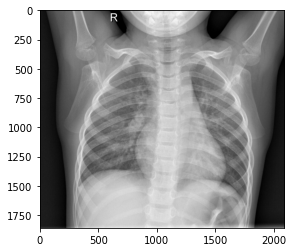

In [22]:
# Load an color image in grayscale
img = cv2.imread(training_images_dir + "/NORMAL/IM-0115-0001.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB colorisation
plt.imshow(img_rgb)

In [23]:
type(img)
img_rgb.shape

(1858, 2090, 3)

In [24]:
list_img = []

def number_of_files(startpath):
    """Print the folder sutructure of a given folder"""
    for root, dirs, files in os.walk(startpath):
        list_img.append(files)

In [25]:
list_img = []
number_of_files(training_images_dir+"NORMAL/")
print("Number of normal lungs :", len(list_img[0]))

Number of normal lungs : 1341


In [26]:
list_img = []
number_of_files(training_images_dir+"PNEUMONIA/")
print("Number of pneumonial lungs :", len(list_img[0]))

Number of pneumonial lungs : 3875


## Datagen

In [27]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1/255
).flow_from_directory(
    training_images_dir,
    target_size=(input_size_1, input_size_2),
    color_mode="rgb",
    class_mode="binary",
    classes=["NORMAL", "PNEUMONIA"],
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


In [28]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255
).flow_from_directory(
        test_images_dir,
        target_size=(input_size_1, input_size_2),
        color_mode="rgb",
        class_mode="binary",
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        shuffle=True,
        seed=42
)

Found 624 images belonging to 2 classes.


1.0


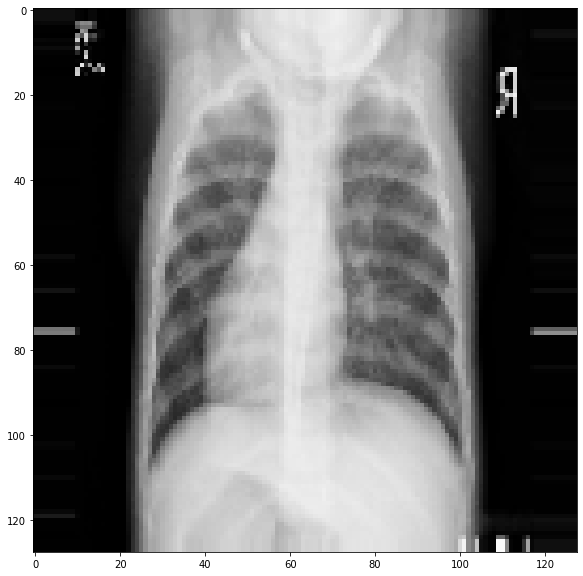

In [29]:
train_iter = iter(train_datagen)
train = train_iter.next()
print(train[1][0])
plt.figure(figsize=(10,10))
plt.imshow(train[0][0])

In [30]:
print("input size : ",input_size_1, input_size_2)
print("dim : ", dim)
print("kernel size : ", kernel_size)
print("Strides : ", strides)
print("output size : ", output_size)

input size :  128 128
dim :  3
kernel size :  (3, 3)
Strides :  (1, 1)
output size :  1


In [31]:
def input_size_sequential(input_size_1, input_size_2, dim):
    return (input_size_1, input_size_2, dim)

In [32]:
input_size_sequential(input_size_1, input_size_2, dim)

(128, 128, 3)

In [64]:
model = models.Sequential()

model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu', input_shape=input_size_sequential(input_size_1, input_size_2, dim)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten()) # 2d to 1d

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(output_size, activation='sigmoid'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 29, 29, 256)       295168    
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 15, 15, 256)     

In [65]:
import tensorflow.keras as keras
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), ])

#  keras.metrics.TruePositives(), keras.metrics.FalsePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives()

In [66]:
epochs = 14
with tf.device('/GPU:0'):

    history = model.fit(train_datagen, epochs=epochs, 
                        validation_data=test_datagen)

Epoch 1/14
163/163 [==============================] - 61s 368ms/step - loss: 0.6363 - binary_accuracy: 0.7409 - recall_4: 0.9299 - auc_4: 0.6553 - val_loss: 0.4460 - val_binary_accuracy: 0.7660 - val_recall_4: 0.9897 - val_auc_4: 0.9279
Epoch 2/14
163/163 [==============================] - 59s 363ms/step - loss: 0.2845 - binary_accuracy: 0.8815 - recall_4: 0.9366 - auc_4: 0.9353 - val_loss: 0.3962 - val_binary_accuracy: 0.8750 - val_recall_4: 0.9359 - val_auc_4: 0.9339
Epoch 3/14
163/163 [==============================] - 59s 362ms/step - loss: 0.2459 - binary_accuracy: 0.9008 - recall_4: 0.9353 - auc_4: 0.9511 - val_loss: 0.4302 - val_binary_accuracy: 0.8510 - val_recall_4: 0.9718 - val_auc_4: 0.9399
Epoch 4/14
163/163 [==============================] - 59s 362ms/step - loss: 0.2098 - binary_accuracy: 0.9179 - recall_4: 0.9482 - auc_4: 0.9625 - val_loss: 0.4016 - val_binary_accuracy: 0.8814 - val_recall_4: 0.9641 - val_auc_4: 0.9412
Epoch 5/14
163/163 [==============================] 

20/20 [==============================] - 5s 239ms/step - loss: 0.3604 - binary_accuracy: 0.9183 - recall_4: 0.9641 - auc_4: 0.9475


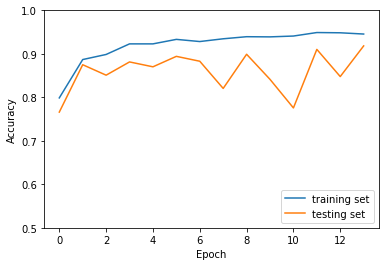

In [67]:
plt.plot(history.history['binary_accuracy'], label='training set')
plt.plot(history.history['val_binary_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

20/20 [==============================] - 5s 242ms/step - loss: 0.3604 - binary_accuracy: 0.9183 - recall_4: 0.9641 - auc_4: 0.9475


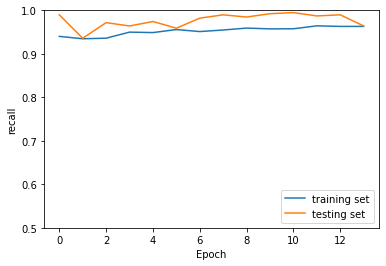

In [69]:
plt.plot(history.history['recall_4'], label='training set')
plt.plot(history.history['val_recall_4'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

20/20 [==============================] - 5s 239ms/step - loss: 0.3604 - binary_accuracy: 0.9183 - recall_4: 0.9641 - auc_4: 0.9475


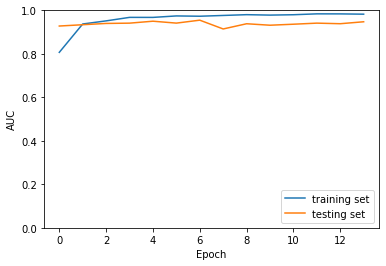

In [70]:
plt.plot(history.history['auc_4'], label='training set')
plt.plot(history.history['val_auc_4'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

In [113]:
model.save('pneumonia_A91_R96_AUC94.h5')

In [86]:
# from tensorflow import keras
# model = keras.models.load_model('./model/pneumonia_A91_R96_AUC94.h5')

1.0


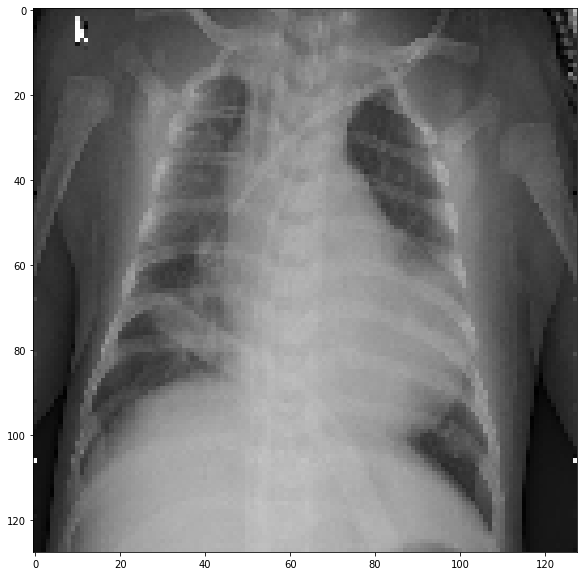

In [112]:
test_iter = iter(test_datagen)
test = test_iter.next()
print(test[1][0])
plt.figure(figsize=(10,10))
plt.imshow(test[0][0])

In [90]:
my_test = np.reshape(test[0][0], ( 1, *test[0][0].shape))

In [91]:
my_test.shape

(1, 128, 128, 3)

In [92]:
np.min(my_test)

0.0

In [93]:
np.max(my_test)

1.0

In [94]:
my_test.dtype

dtype('float32')

In [95]:
model.predict(my_test)

array([[0.9991035]], dtype=float32)